# Homework - Categorization and Model Comparison Part B (40/110 points)

by *Todd Gureckis* and *Brenden Lake*  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/  

<div class="alert alert-danger" role="alert">
  This homework is due before midnight on April 25 2022. 
</div>

---

In [1]:
from IPython.display import display
import string as str
import os
import numpy as np
import seaborn as sns
import pandas as pd
import math
from random import random, randint, shuffle, uniform
from scipy.optimize import fmin, brute
from scipy.special import comb # gets the combinations function
from exemplarproto import *  # this grabs much of the code from Part A of the homework

## Fitting the models using maximum likelihood

As mentioned in the lecture, RMSE is not always an ideal mechanism for fitting models.  One reason is that it is insensitive to the number of observations that define each data point.  For example, remember in our experiment that participants saw the prototype item four times at test.  In contrast, there were 20 different "new" patterns.  This means there are five times as many trials contributing to the "new" bar in this graph as for the prototype patterns.  Since RMSE measures the raw deviation of the average model predictions from those of the model it doesn't take into account these issues.  Thus, we would like to also evaluate these two models using maximum likelihood.

The key to this is going to be the provided function below which computes the likelihood of a particular set of data under a binomial probability model.:

In [2]:
################################
# computeLogLikelihood
# N = number of observations
# S = number of "successes" (i.e., endorsements)
# p = predicted probability of successes by the model
################################
def computeLogLikelihood(N, S, p):
    p = p if p > 0.0 else 0.0+1e-10
    p = p if p < 1.0 else 1.0-1e-10
    try:
        result = math.log(comb(N, S)) + (S*math.log(p) + (N-S)*math.log(1.0-p))
    except:
        print(N, S, p)  # this shouldn't happen but just in case
        result = 0
    return result


def pandas_ll(row):
    return computeLogLikelihood(row['Total'], row['N_Yes'], row['Probability of Endorsement'])

A short explanation may be in order: the models predictions take the form of probabilities of endorsement for each of the prototype, low, high, random, and old items. If you find out that people endorse the prototype on 2 out of 2 trials how likely is this outcome given that the model (for a particular set of parameters ) predicts an endorsement of p=0.8? Three numbers are required to do this for each data point N, the number of trials/presentations within the stimulus class, S the number of successes observed (S<=N), and p the predicted probability. Then you can turn the crank on the above `computeLogLikelihood()` function which returns the probability that you would get $S$ successes in $N$ trials if the true probability was $p$ (make sure you understand what is happening in `computeLogLikelihood`). You can sum these log likelihoods for each stimulus class (prototype, low, high, random, old) to compute a total log(likelihood) of the data for any given model with any set of parameters.   For this homework will we focus on fitting the group data rather than to individuals.

To get the data formatted into an appropriate shape for fitting likelihoods we provide a function `get_human_results_ll()` which returns a Pandas data frame containing the number of times a pattern of a particular type was endorsed and the number of times it was presented for each subject.

In [3]:
human_res=get_human_results_ll()
human_res

,Subject,Condition,Stimulus Type,N_Yes,Total
0,./data/8.dat,cat,Prototype,4,4
1,./data/8.dat,cat,Low,4,4
2,./data/8.dat,cat,High,10,10
3,./data/8.dat,cat,Random,15,20
4,./data/8.dat,cat,Old,20,20
...,...,...,...,...,...
0,./data/7.dat,rec,Prototype,3,4
1,./data/7.dat,rec,Low,4,4
2,./data/7.dat,rec,High,8,10
3,./data/7.dat,rec,Random,0,20


This reorganizes the data per condition.

In [4]:
human_data=human_res.groupby(['Condition','Stimulus Type']).sum()
human_data

N_Yes  Total
Condition Stimulus Type              
cat       High              49     70
          Low               26     28
          Old              110    140
          Prototype         25     28
          Random            37    140
rec       High              20     70
          Low               16     28
          Old               89    140
          Prototype         18     28
          Random             7    140

Finally these function allow us to compute the negative log likelihood of the data given the model.

In [5]:
def fit_exemplar_model_nll(params, human_results):
    [c_cat, k_cat, c_rec, k_rec] = params
    k_cat = k_cat if k_cat > 0.0 else 0.0
    k_rec = k_rec if k_rec > 0.0 else 0.0
    predictions = get_exemplar_results(c_cat, k_cat, c_rec, k_rec)
    model = predictions.groupby(
        ['Condition', 'Stimulus Type'], as_index=False).mean()
    fitted_data = pd.merge(model, human_results)
    return -1.0*fitted_data.apply(pandas_ll, axis=1).sum()


def fit_prototype_model_nll(params, human_results):
    [c_cat, k_cat, c_rec, k_rec] = params
    k_cat = k_cat if k_cat > 0.0 else 0.0
    k_rec = k_rec if k_rec > 0.0 else 0.0
    predictions = get_prototype_results(c_cat, k_cat, c_rec, k_rec)
    model = predictions.groupby(
        ['Condition', 'Stimulus Type'], as_index=False).mean()
    fitted_data = pd.merge(model, human_results)
    return -1.0*fitted_data.apply(pandas_ll, axis=1).sum()

<div class="alert alert-success" role="alert">
<h3> Problem 6 (20 points) </h3><br>
The cell blocks below allow you to fit the exemplare model and the prototype model to the dataset we considered in Part A of the homework. Make sure you understand and follow the code provided above and in the provided library (exemplarproto.py).  Next, try altering the parameters to minimize the negative log likelihood score.  When you think you have found the best fit parameters for both the exemplar and prototype models report your final parameter values along with the plot of the resulting model predictions.  In a markdown cell describe which model you believe fits better.  Is this conclusion the same or different from what you considered in Part 4 of the homework?  If the fit looks different, why?
</div>

<div class="alert alert-success" role="alert">
<h3> Problem 6 Answer </h3><br>
The parameters that minimize the negative log likelihood score are: 
    
    Exemplar: params = [1.5, 0.3, 1.9, 0.78], with the negative log score of 29.24864237575493
    Prototype: params = [1.6, 0.03, 1.87, 0.1], with the negative log score of 33.165423291348205
    
    
I believe exemplar model fit better since it have a smaller value of negative log score. This is the same as the conclusion in part A Question 4.
    
The overall fit of these two model mathes with human results. In the Exemplar model, the old simulus have a highest probability of endorsement. Since the exemplar model memorize every item in the training set, when a identical item shows, the model will be able to retrive the memory. By comparing two identical item, a high similarty(e^sij=1) would lead to the higher probability of endorsement. 
Meanwhile, in the prototype model, the prototype simulus have the highest probability of endorsement. In the prototype model, an average prototype is memorize for the category. Under the prototype simulus, it would produce a similar items to the prototype. Thus it would lead to higher probability of endorsement. 

   
</div>

**Exemplar model**

The negative log score is 29.24864237575493


<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

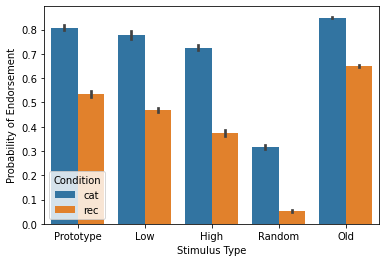

In [83]:
human = human_res.groupby(['Condition', 'Stimulus Type'], as_index=False).sum()

params = [1.5, 0.3, 1.9, 0.78]
nllfit = fit_exemplar_model_nll(params, human)
print(f'The negative log score is {nllfit}')

# now plot the data
c_cat, k_cat, c_rec, k_rec = params
res = get_exemplar_results(c_cat, k_cat, c_rec, k_rec)
sns.barplot(x="Stimulus Type", y="Probability of Endorsement",
            hue="Condition", data=res)

**Prototype Model**

The negative log score is 33.165423291348205


<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

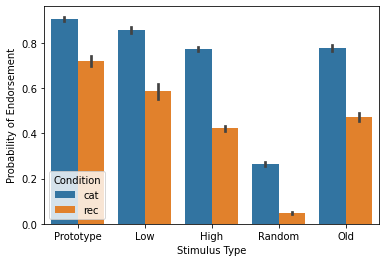

In [85]:
human = human_res.groupby(['Condition', 'Stimulus Type'], as_index=False).sum()

params = [1.6, 0.03, 1.87, 0.1]
nllfit = fit_prototype_model_nll(params, human)
print(f'The negative log score is {nllfit}')

# now plot the data
c_cat, k_cat, c_rec, k_rec = params
res = get_prototype_results(c_cat, k_cat, c_rec, k_rec)
sns.barplot(x="Stimulus Type", y="Probability of Endorsement",
            hue="Condition", data=res)

**Human data again for reference**

<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

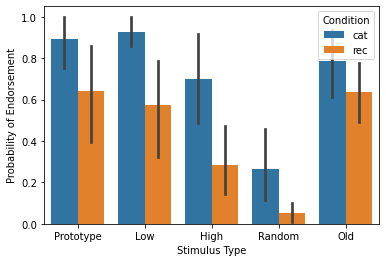

In [8]:
sns.barplot(x="Stimulus Type", y="Probability of Endorsement",
            hue="Condition", data=get_human_results())

<div class="alert alert-success" role="alert">
<h3> Problem 7 (10 points) </h3><br>
A famous saying is the "All models are wrong, but some are useful" (George Box).  Do you think the exemplar or prototype model provides the best account of the data?  Refer to particular patterns in the data that you believe the different models do a better job with.
</div>

<div class="alert alert-success" role="alert">
<h3> Problem 7 Answer </h3><br>
    Exemplar or Prototype would perform differently under different condition, but both perform well. Exemplar model suggests that it categorize objects by storing every past object, and use past experience to find the general class. Meanwhile, prototype model store a single summary representation that captures the central tendency of the category. Exemplar perform better than prototype under the old simulus. Under the rec condition, exemplar model have a better fit with human results. Under the cat condition, prototype model would have a better fit with human results. 
    
Both models have their own strength and weakness. Exemplar model may do a better job when the new item is hightly similar to those presented before(old simulus). Prototype model may do a better job when examples are having similar features and correlated tendency, which can lead to a distinct categoty(prototype simulus). 

<div class="alert alert-success" role="alert">
<h3> Problem 8 (5 points) </h3><br>

Thinking about how these models work explain why both the exemplar and prototype models have relatively high endorsement for the prototype item even though it was never presented during the training phase.  In addition, explain in your own words why the models are able to explain the high endorsement rates for the old items.
    
</div>

<div class="alert alert-success" role="alert">
<h3> Problem 8 Answer </h3><br>
    Both model have high probability of endorsement for the prototype. For exemplar model, when a new item shows similar to the exemplars, there would be a higher chance that the new item would receive endorsement. Because in the exemplar model, the probability of endorsement is based on all previous examples. Since the prototype would have silimar feature to all the previous examples, it would have a high endorsement. For prototype model, people categorize objects based on a single summary representation that captures the central tendency of the category. when the new prototype simulus presented, it can matches some of the feature of the category, it would have a higher chance to receive a higher probability of endorsement. 
    
Both model have high endorsement rates for the old items. For exemplar model, when the model encounter a item that is already in the memory, it would retrive their memory. Since the old item is identical relative to the exemplars, there would be a large e^sij value presented. Thus higher probability of endorsement it would get. For prototype model, people have a prototype representation in memory for each category based on the training set. Since the old item is identical to those presented during the training phase, when people compare the old item to the prototype representation, there would be a high similarity and high probability of endorsement. 

<div class="alert alert-success" role="alert">
<h3> Problem 9 (5 points) </h3><br>

Are the exemplar model and the prototype model we considered nested?  Would we compare them using AIC, BIC, or the G^2 statistic (or something else)?

</div>

<div class="alert alert-success" role="alert">
<h3> Problem 9 Answer </h3><br>
Exemplar model and prototype model are not nested. While a prototype is an abstract average of the members of a category, an exemplar is an actual member of a category, pulled from memory.
    
We would compare them using AIC, BIC. AIC and BIC can be used to measure non-nested model. They take into account both the goodness-of-fit of the model and the complexity of the model. The model with the lower AIC or BIC score is considered to be the better fit, given the trade-off between model complexity and goodness-of-fit. For G^2 statistics, it only works for nested model. So, it is not applicable here. 
    
For non-nested models, we can also use cross-validation, Baysian model comparison, or likelihood ratio test to compare exemplar and prototype. 